Problema a tiempo directo
\begin{align}
-\partial_t \varphi - \gamma \Delta \varphi = v \chi_O, \quad \Omega,\\
\varphi = 0, \quad \partial \Omega \times (0, \tau),\\
\varphi(x, \tau) = \varphi_0, \quad \Omega,\\
\varphi(x, 0) = 0, \quad \Omega
\end{align}

Problema a tiempo inverso: $\Phi(x, t) = \varphi(x, \tau - t)$
\begin{align}
\partial_t \Phi - \gamma \Delta \Phi = v \chi_O, \quad \Omega,\\
\Phi = 0, \quad \partial \Omega \times (0, \tau),\\
\Phi(x, 0) = \varphi_0, \quad \Omega,\\
|| \Phi(x, \tau) || < \epsilon, \quad \Omega
\end{align}

In [1]:
tau = 0.1

In [2]:
from dolfin import *
from dolfin_adjoint import *
import numpy as np
set_log_level(LogLevel.WARNING)

In [143]:
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)
tol = 1e-14
# Defining bounday conditions

def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS
uD = Constant(0.0)
bc = DirichletBC(V, uD, boundary)

In [4]:
ind_O = interpolate(Expression('1/3 <= x[1] <= 2/3 ? 0.0 : 1.0', degree=4), V)

In [5]:
phi0 = Function(V, '../step_0/Eigenfunction_1.xml')

In [6]:
# Resolving the variational formulation    
dt = 0.0025

# u0 = interpolate(u0_opt, V)
u0 = interpolate(Expression("0.0", degree=4), V)
u = u0.copy(deepcopy=True)

phi_prev = phi0.copy(deepcopy=True) 
phi_next = phi0.copy(deepcopy=True) 

T = tau
t = 0.0
v = TestFunction(V)

states = [phi0.copy(deepcopy=True)]
controls = [u0.copy(deepcopy=True) ]
times = [float(t)]
timestep = 0

In [7]:
while abs(T-t)>=tol :
    print("Solving for t == %s" % (t + dt))
#     u.assign(u0, annotate=True)
    
    F = inner((phi_next - phi_prev) / Constant(dt), v) * dx + inner(grad(phi_next), grad(v)) * dx - (u * ind_O) * v * dx
    solve(F == 0, phi_next, bc, annotate=True) # This is how dolfin-adjoint records the dependency of the control in each timestep
    
    phi_prev.assign(phi_next, annotate=True)
    
    t += dt
    timestep += 1
    
    states.append(phi_next.copy(deepcopy=True, annotate=True))
#     controls.append(u.copy(deepcopy=True, annotate=True))
    
    times.append(float(t))
    print("Done!")

Solving for t == 0.0025
Done!
Solving for t == 0.005
Done!
Solving for t == 0.0075
Done!
Solving for t == 0.01
Done!
Solving for t == 0.0125
Done!
Solving for t == 0.015000000000000001
Done!
Solving for t == 0.0175
Done!
Solving for t == 0.02
Done!
Solving for t == 0.0225
Done!
Solving for t == 0.024999999999999998
Done!
Solving for t == 0.027499999999999997
Done!
Solving for t == 0.029999999999999995
Done!
Solving for t == 0.032499999999999994
Done!
Solving for t == 0.034999999999999996
Done!
Solving for t == 0.0375
Done!
Solving for t == 0.04
Done!
Solving for t == 0.0425
Done!
Solving for t == 0.045000000000000005
Done!
Solving for t == 0.04750000000000001
Done!
Solving for t == 0.05000000000000001
Done!
Solving for t == 0.05250000000000001
Done!
Solving for t == 0.055000000000000014
Done!
Solving for t == 0.057500000000000016
Done!
Solving for t == 0.06000000000000002
Done!
Solving for t == 0.06250000000000001
Done!
Solving for t == 0.06500000000000002
Done!
Solving for t == 0.0675

In [8]:
import matplotlib.pyplot as plt

In [9]:
# # t = 0
# img = []
# for i in range(100):
#     row = []
#     for j in range(100):
#         row.append(states[t]([i/99,j/99]))
#     img.append(row)
# plt.imshow(img, vmin=0, vmax=2)
# plt.title(t)
# t+=5

In [10]:
len(states)

41

In [11]:
# heat = File("heat.pvd")
# state = Function(V, name="state")
# for i in range(len(states)):
#     si = states[i]
#     state.vector().zero()
#     state.vector().axpy(1, si)
#     heat << state

In [12]:
%%time
steps=len(times)

combined = zip(times,controls)
alpha = Constant(0.5)
# and the minimizing problem
J = assemble(phi_next*phi_next*dx)
m = Control(u)#[Control(c) for c in controls]
RJ = ReducedFunctional(J,m)

u0_opt = minimize(RJ,tol=1.0e-10, options={"ftol": 1e-7})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1089     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75717D-05    |proj g|=  7.90750D-07

At iterate    1    f=  3.89962D-05    |proj g|=  5.27702D-07

At iterate    2    f=  4.31200D-11    |proj g|=  2.27329D-10
CPU times: user 5.34 s, sys: 438 ms, total: 5.78 s
At iterate    3    f=  3.27991D-11    |proj g|=  1.94999D-10

Wall time: 10.9 s

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1089      3      5      1     0     0   1.950D-10   3.280D-11
 

In [13]:
u0_opt([2/3, 2/3])

3.7002922696907093e-13

In [14]:
u0_opt.rename('u','u')

u0 = interpolate(u0_opt, V)
u = u0.copy(deepcopy=True)

phi_prev = phi0.copy(deepcopy=True) 
phi_next = phi0.copy(deepcopy=True) 

T = tau
t = 0.0
v = TestFunction(V)

states = [phi0.copy(deepcopy=True)]
controls = [u0.copy(deepcopy=True) ]
times = [float(t)]
timestep = 0
file = File('NullControls/sol.pvd')
states[-1].rename('phi','phi')
file << (states[-1], 0)
while abs(T-t)>=tol :
    print("Solving for t == %s" % (t + dt))
    
    F = inner((phi_next - phi_prev) / Constant(dt), v) * dx + inner(grad(phi_next), grad(v)) * dx - (u * ind_O) * v * dx
    solve(F == 0, phi_next, bc, annotate=True) # This is how dolfin-adjoint records the dependency of the control in each timestep
    
    phi_prev.assign(phi_next, annotate=True)
    
    t += dt
    timestep += 1
    
    states.append(phi_next.copy(deepcopy=True, annotate=True))
    
    times.append(float(t))
    states[-1].rename('phi','phi')
    
    file << (states[-1],t)
    
    print("Done!")

Solving for t == 0.0025
Done!
Solving for t == 0.005
Done!
Solving for t == 0.0075
Done!
Solving for t == 0.01
Done!
Solving for t == 0.0125
Done!
Solving for t == 0.015000000000000001
Done!
Solving for t == 0.0175
Done!
Solving for t == 0.02
Done!
Solving for t == 0.0225
Done!
Solving for t == 0.024999999999999998
Done!
Solving for t == 0.027499999999999997
Done!
Solving for t == 0.029999999999999995
Done!
Solving for t == 0.032499999999999994
Done!
Solving for t == 0.034999999999999996
Done!
Solving for t == 0.0375
Done!
Solving for t == 0.04
Done!
Solving for t == 0.0425
Done!
Solving for t == 0.045000000000000005
Done!
Solving for t == 0.04750000000000001
Done!
Solving for t == 0.05000000000000001
Done!
Solving for t == 0.05250000000000001
Done!
Solving for t == 0.055000000000000014
Done!
Solving for t == 0.057500000000000016
Done!
Solving for t == 0.06000000000000002
Done!
Solving for t == 0.06250000000000001
Done!
Solving for t == 0.06500000000000002
Done!
Solving for t == 0.0675

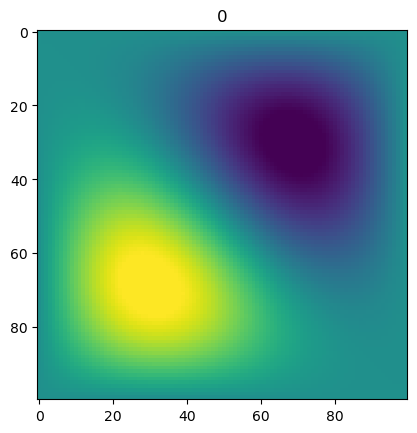

In [15]:
t = 0
img = []
for i in range(100):
    row = []
    for j in range(100):
        row.append(states[t]([i/99,j/99]))
    img.append(row)
plt.imshow(img, vmin=-2, vmax=2)
plt.title(t)
t+=1

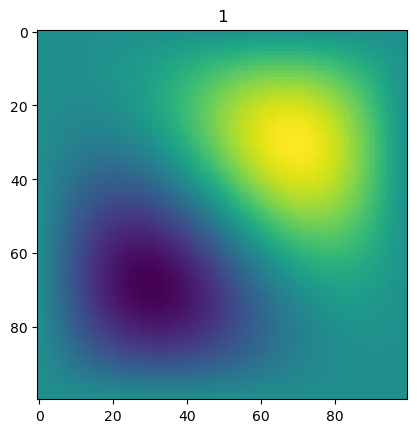

In [16]:
t = 1
img = []
for i in range(100):
    row = []
    for j in range(100):
        row.append(u0_opt([i/99,j/99]))
    img.append(row)
plt.imshow(img)
plt.title(t);

In [196]:
import pickle

In [197]:
%%time
dim = V.dim()
N = mesh.geometry().dim()
coor = V.tabulate_dof_coordinates().reshape(dim,N)

x = coor[:, 0]
y = coor[:, 1]

pickle.dump(
    {
        "control": u0_opt.vector()[:],
        "x": x, 
        "y": y
    },
    open("Control.pickle", "wb")
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 35.3 ms


array([ 0.        ,  0.00211264,  0.00211264, ..., -0.00211264,
       -0.00211264,  0.        ])

In [167]:
f_dofs = V.dofmap().dofs()
f_dofs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [171]:
f_x, f_y = x[f_dofs], y[f_dofs]
f_x, f_y

(array([0.     , 0.     , 0.03125, ..., 0.96875, 1.     , 1.     ]),
 array([1.     , 0.96875, 1.     , ..., 0.     , 0.03125, 0.     ]))

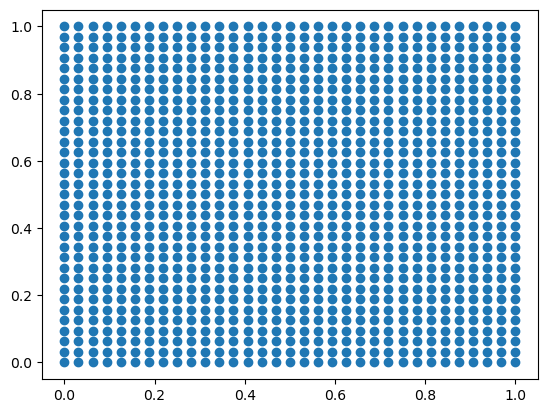

In [177]:
plt.scatter(f_x, f_y)

In [179]:
fe = Function(V)

In [192]:
fe.vector()[f_dofs] = np.sin(np.pi*f_x*2) + 5*f_y

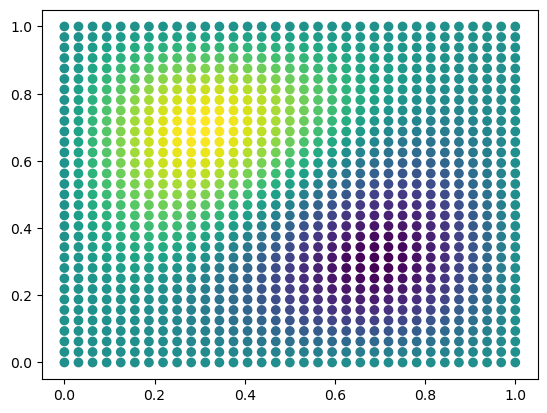

In [194]:
plt.scatter(f_x, f_y, c=u0_opt.vector()[f_dofs])

In [54]:
interpolate(u0_opt.vector(), V)

AttributeError: 'dolfin.cpp.la.PETScVector' object has no attribute '_cpp_object'

# u0_opt.vector().array()
https://fenicsproject.org/qa/3975/interpolating-vector-function-from-python-code-to-fenics/